In [89]:
import os
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
DATA_PATH = 'Data/'

def download_data():
    data_url = 'http://timeseriesclassification.com/Downloads/ItalyPowerDemand.zip'
    resp = urlopen(data_url)
    zipfile = ZipFile(BytesIO(resp.read()))
    #fnames = zipfile.namelist()
    data = np.array([list(map(float, line.strip().split())) 
                     for line in zipfile.open('ItalyPowerDemand_TRAIN.txt').readlines()])
    xtrain, ytrain = data[:,1:],data[:,0]
    data = np.array([list(map(float, line.strip().split())) 
                     for line in zipfile.open('ItalyPowerDemand_TEST.txt').readlines()])    
    xtest, ytest = data[:,1:],data[:,0]
    return xtrain, ytrain, xtest, ytest

def eval_cluster_result(clmembership,labelvector):
    cluster_metric = {}
    cluster_metric["Adjusted Rand"] = metrics.adjusted_rand_score(labelvector, clmembership)  
    cluster_metric["Adjuster Mutual Info"] = metrics.adjusted_mutual_info_score(labelvector, clmembership)  
    cluster_metric["Normalized Mutual Info"] = metrics.normalized_mutual_info_score(labelvector, clmembership)  
    cluster_metric["Fowlkes Mallows"] = metrics.fowlkes_mallows_score(labelvector, clmembership)
    return cluster_metric         

# Load ItalyPowerDemand Data

In [24]:
fname = "ItalyPowerDemand.npy"

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
if not os.path.isfile(os.path.join(DATA_PATH,fname)):
    xtrain, ytrain, xtest, ytest = download_data()
    np.save(open(os.path.join(DATA_PATH,fname),'wb'),[xtrain, ytrain, xtest, ytest])
else:
    xtrain, ytrain, xtest, ytest = np.load(open(os.path.join(DATA_PATH,fname),'rb'))

# Currently not used:
## Load other UCR/UEA Datasets


In [30]:
from tslearn.datasets import UCR_UEA_datasets


UCR_dataset = UCR_UEA_datasets()
UCR_dataset._data_dir = DATA_PATH
dataset_names = UCR_dataset.list_datasets()
if False:
    dname = 'ItalyPowerDemand'
    train, labels_train, test, labels_test = UCR_dataset.load_dataset(dname)
    data = [d[~np.isnan(d)].reshape((-1, train.shape[-1])) for d in np.concatenate([train, test])]
    labels = np.concatenate([labels_train, labels_test])

# Cluster ItalyPowerDemand

#### Standardization will have no effect since data hardly changes
Data basically already has mean zero and unit variance

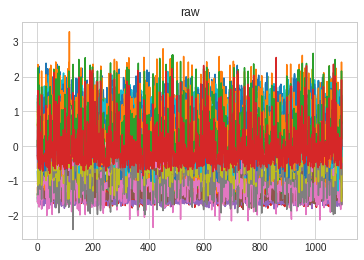

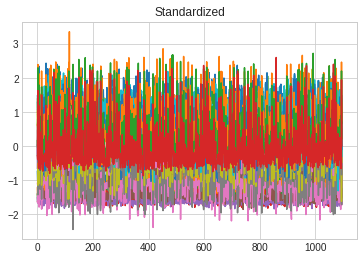

In [93]:
% matplotlib inline
scaler = StandardScaler()
data_scaled = (scaler.fit_transform(data.T)).T

plt.plot(data)
plt.title("raw")
plt.show()
plt.plot(data_scaled)
plt.title("Standardized")
plt.show()

## comparison kmeans vs other clustering algorithms

### 1.1) kmeans with euclidean distance

In [29]:
from tslearn.clustering import TimeSeriesKMeans
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [37]:
data = np.vstack((xtrain,xtest))
labels = np.hstack((ytrain,ytest))
lunique = np.unique(labels)

In [73]:
clusters_pred = TimeSeriesKMeans(n_clusters = lunique.size, verbose=0, metric="euclidean").fit_predict(data)
scores = eval_cluster_result(clusters_pred,labels)
pp.pprint(scores)

{   'Adjusted Rand': 0.0003042317856477543,
    'Adjuster Mutual Info': 0.00045093353922105413,
    'Fowlkes Mallows': 0.5915539841857232,
    'Normalized Mutual Info': 0.001339382413808777}


### 1.2) kmeans with dynamic time warping (WARNING: slow)

In [94]:
clusters_pred = TimeSeriesKMeans(n_clusters = lunique.size, verbose=0, metric = "dtw").fit_predict(data)
scores = eval_cluster_result(clusters_pred,labels)
pp.pprint(scores)

{   'Adjusted Rand': 0.002875739739489766,
    'Adjuster Mutual Info': 0.003735617343719333,
    'Fowlkes Mallows': 0.595583974114272,
    'Normalized Mutual Info': 0.005345081191037978}


### 1.3) kmeans with soft dtw (WARNING: slow)

In [95]:
clusters_pred = TimeSeriesKMeans(n_clusters = lunique.size, verbose=0, metric = "softdtw").fit_predict(data)
scores = eval_cluster_result(clusters_pred,labels)
pp.pprint(scores)

{   'Adjusted Rand': 0.0001087678421236584,
    'Adjuster Mutual Info': 0.00017012295810155397,
    'Fowlkes Mallows': 0.5696692771993817,
    'Normalized Mutual Info': 0.0009445136728954779}


### Many  clustering algorithms can work with an affinity matrix. So we will first create affinity matrices and the run different cluster algorithms on them.

For a pointwise distance we will use an rbf kernel, since it has a tight connection to the euclidean distance.

In [100]:
from sklearn.metrics.pairwise import pairwise_kernels
#rbf kernel with scaling set to 1.0 / n_features
affinity_matrix_rbf = pairwise_kernels(data, metric='rbf')

### 1.4) Spectral Clustering

In [103]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters= lunique.size,  n_init=10, gamma=1.0, affinity='precomputed', eigen_tol=0.0, n_jobs=1)

In [107]:
clusters_pred = model.fit_predict(affinity_matrix_rbf)
scores = eval_cluster_result(clusters_pred,labels)
pp.pprint(scores)

{   'Adjusted Rand': 0.0020509259982484317,
    'Adjuster Mutual Info': 0.0025620604003189743,
    'Fowlkes Mallows': 0.5893844122779508,
    'Normalized Mutual Info': 0.0038513549596466213}


### 1.5) Spectral Clustering with warping distance (Triangular Global Alignment Kernel)
To run this, you will have to download the  triangular global alignment kernel implementation and compile it. 

Download python wrapper and compile: http://marcocuturi.net/Code/TGA_python_wrapper_v1.0.tar.gz

More details: http://marcocuturi.net/GA.html


In [112]:
import TGA_python_wrapper.global_align as t_global_align

def mean_distance(ts_list):
    """
        Estimates the mean distance between time series
    
        Arguments:
            ts_list {List of Series} -- List of the time series
        
        Returns:
            Float -- Mean Distance between the different time series
    """
    # TODO : Check this function and better estimate of the mean distance 
    # Between time series
    all_time = np.concatenate(ts_list, axis = 0)
    return np.linalg.norm(all_time.mean(axis = 0)) + all_time.std(axis = 0).sum()

def compute_tga(ts_list, sigma, triangular):
    """
        Computes TGA kernel of the list of time series
    
        Arguments:
            ts_list {List of Series} -- Time Series List
            sigma {float} -- [description]
            triangular {int} -- [description]
        
        Returns:
            Array len(ts_list)^2 -- Kernel
    """
    tga_kernel = np.ones((len(ts_list), len(ts_list)))
    for i, ti in enumerate(ts_list):
        for j, tj in enumerate(ts_list[:i]):
            tga_kernel[i, j] = np.exp(-t_global_align.tga_dissimilarity(ti, tj, sigma, triangular))
            tga_kernel[j, i] = tga_kernel[i, j]
    return tga_kernel  

#### Using a large warping window

In [119]:
time_len_sqrt = np.sqrt(np.median([len(ts) for ts in data]))
distance = mean_distance([ts for ts in data])
sigmas = np.array([0.5, 1.0, 5.0]) * time_len_sqrt * distance
for _s in sigmas:
    print("sigma: {}".format(_s))
    _K = compute_tga([ts.reshape(-1,1) for ts in data], _s, 0.9)
    clusters_pred = model.fit_predict(_K)
    scores = eval_cluster_result(clusters_pred,labels)
    pp.pprint(scores)
    print('*'*40)

sigma: 2.397915761492455
{   'Adjusted Rand': 0.007041635948749205,
    'Adjuster Mutual Info': 0.0075460136925798345,
    'Fowlkes Mallows': 0.5740261054431411,
    'Normalized Mutual Info': 0.009366310609573407}
****************************************
sigma: 4.79583152298491
{   'Adjusted Rand': 0.001055520580419966,
    'Adjuster Mutual Info': 0.0013664088509507605,
    'Fowlkes Mallows': 0.5899274528173991,
    'Normalized Mutual Info': 0.0024290221178298902}
****************************************
sigma: 23.979157614924553
{   'Adjusted Rand': 0.0017292214554661051,
    'Adjuster Mutual Info': 0.0023400960812435144,
    'Fowlkes Mallows': 0.5980821609045164,
    'Normalized Mutual Info': 0.003681828140048846}
****************************************
